# Collect and Analyze a Twitter Network
[Effrosyni Simou](http://lts4.epfl.ch/simou), *PhD Student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
In this way you will have this information readily available to you. 

In [244]:
%matplotlib inline

import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import tweepy  # you will need to install tweepy first
# We want to visualize the network we create, to do so we will use networkx
import networkx as nx # WARNING: Library not included in the standard notebook

In [209]:
# Variable used to print degug information in this notebook
DEBUG_INFO = True

In [210]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

#authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [211]:
user = 'msf'
user_id=api.get_user(user).id

In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user.

In [212]:
def find_connections(user_id,nbr_of_pages=1):
    followers = []
    friends=[]
    try:
        for part_friends in tweepy.Cursor(api.friends_ids, id=user_id).pages(nbr_of_pages):
            friends.extend(part_friends)
        for part_followers in tweepy.Cursor(api.followers_ids, id=user_id).pages(nbr_of_pages):
            followers.extend(part_followers)
    except tweepy.TweepError as e:
        # Manage errors from the tweepy API. We simply print the error information
        print("Error while finding connections!\n\tReason:",
              "{}\n\tResponse: {}\n\tAPI Code: {}".format(e.reason, e.response, e.api_code))
        return []
    else:
        connections = np.intersect1d(friends, followers)
        # Print some debug information related to the s
        if DEBUG_INFO:
            print("{} has {} connections from {} friends and {} followers when using {} pages".format(
                user_id, len(connections), len(friends), len(followers), nbr_of_pages)
                 )
        return connections

In [213]:
# Change the value of nbr_of_pages to obtain more friends_ids and followers_ids
# Warning : If the page number is too high, we will run into rate limitation!
# Note: If this nbr_of_pages is not high enough, we might miss connections in
#       in the subsequent checks. Though, this will only happen for very large
#       following (1 page = 5000 followers). We accept this tradeoff to actually
#       get data in a reasonable time
nbr_of_pages=10
first_connections=find_connections(user_id,nbr_of_pages)
print('{}has {} connections'.format(user, len(first_connections)))

2195671183 has 112 connections from 1215 friends and 50000 followers when using 10 pages
msfhas 112 connections


In [214]:
print(first_connections)

[           8220122           11351772           15719971
           16834046           19177501           20433037
           20504947           20588986           20838866
           21303235           21835209           24908307
           25999480           26786894           31809636
           39219494           39483072           43075399
           51978298           61638283           73149690
           73617824           77485114           97219875
          105862849          109589216          111664235
          113398253          117180358          131896078
          138505765          191821461          215966785
          227459248          230169472          243851678
          247445228          252555813          260160888
          260288018          278992923          300759553
          305426621          375787968          391380430
          394103111          394326921          406433649
          459236731          488570234          529350142
          5559

Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [215]:
network={}
 # Keep track of every connections and not only the ones in the network
 # This is a big optimization with regard to twitter api calls   
connections_dict={}
first_nodes=[]
second_nodes=[]
how_many=20 #This is the number of connections you are sampling. 
            #Keep small (e.g.3) for development, larger later (e.g. 10)
first_nodes=np.random.choice(first_connections, size=how_many,replace=False)

**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [216]:
network[user_id] = first_nodes
connections_dict[user_id] = first_connections

In [220]:
pprint(network)

{21303235: array([         364947550,          193139845, 811229675758505984,
                 31138458,          339167120,          171553499,
               2755624355,          128797906,         3027577229,
               1946493157,           12594872,         1592812808,
                 15982558,           25495787,           16145473,
                369907191,           17650854,           44734487,
                412101247,         2414093978,         2195671183]),
 24908307: array([          25495787, 790214798675968000,          132117893,
                 17774661,         1223916560,         2457852176,
                945307062,          958634641,           17093617,
                 14755286,           17467699,           14755379,
                 60914314,          130643590,            8515342,
                 27643435,           57683930, 788349702194552832,
                 81131370,           31809636,         2195671183]),
 25999480: array([ 561524975, 143066

Lets find the connections of the second nodes

In [222]:
# Loop over the nodes that are linked to the user_id
# The goal is to find second nodes for each of those nodes
# And to populate both the second_nodes array and the network dict
for node in first_nodes:
    # try/except/else for the case where the argument to np.random.choice is bad.
    # It happens when the node doesn't allow us to check for its connections
    try:
        found_connections = find_connections(node,nbr_of_pages)
    except:
        print("The connections for node {} could not be gathered".format(node))
        network[node] = []
        connections_dict[node] = []
    else:
        # If there's not enough found connections...
        try:
            connections_to_add = np.random.choice(found_connections, size=how_many, replace=False)
        # Add as many as possible
        except:
            connections_to_add = found_connections
        # Avoid having user_id as a second level connection
        # We just remove it from the array in this case
        if user_id in connections_to_add:
            index_to_del = np.where(connections_to_add == user_id)
            connections_to_add = np.delete(connections_to_add, index_to_del)
        second_nodes.extend(connections_to_add)
        # Add the source node and the connections nodes
        network[node] = np.append(connections_to_add, user_id)
        connections_dict[node] = found_connections

77485114 has 64 connections from 131 friends and 3562 followers when using 10 pages
24908307 has 77 connections from 172 friends and 6715 followers when using 10 pages
2937510192 has 27 connections from 93 friends and 42 followers when using 10 pages
953834312 has 64 connections from 215 friends and 122 followers when using 10 pages
25999480 has 96 connections from 394 friends and 218 followers when using 10 pages
300759553 has 122 connections from 145 friends and 201 followers when using 10 pages
2401220294 has 175 connections from 430 friends and 469 followers when using 10 pages
Rate limit reached. Sleeping for: 434
113398253 has 423 connections from 4928 friends and 50000 followers when using 10 pages
529350142 has 294 connections from 874 friends and 955 followers when using 10 pages
51978298 has 188 connections from 521 friends and 18827 followers when using 10 pages
809756465871331328 has 38 connections from 1007 friends and 136 followers when using 10 pages
Rate limit reached. 

In [234]:
all_nodes=np.concatenate((first_nodes, second_nodes))

In [235]:
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 20 first hop nodes
There are 599 second hop nodes
There are overall 619 nodes in the collected network


In [236]:
for i in second_nodes:
    network[i]=[]
    connections_dict[i]=[]

Find the inner connections between your collected nodes that you might have missed because you sampled the connections.

In [237]:
def should_add_node_as_connection(source, target):
    """This function take a source node and a target node and says if they are connections
        It assumes the dictionnary "network" has been declared in the environment
    """
    # Check for various cases
    # 1) it is source
    if target == source:
        return False
    # 2) it is already a connection of source
    elif target in network[source]:
        return False
    # 3) Check if we have the required information in the small dict
    elif source in network[target]:
        return True
    # 4) Otherwise use the connections dict
    elif source in connections_dict[target]:
        return True
    elif target in connections_dict[source]:
        return True
    else:
        return False

In [238]:
pprint(network)

{48093: [],
 7137782: [],
 8220122: array([  10722752,  261232011,   66320467,   34357036,  255377355,
          8752562,   14316614,  376134640, 3384551488,   34361745,
         55896553,  479076506,  386373619,   73529539,   19993635,
         14569462,  319288489,  301998990,   25811993, 2238185864,
       2195671183]),
 8515342: [],
 8752562: [],
 10722752: [],
 10796602: [],
 12048252: [],
 12594872: [],
 13006932: [],
 14047971: [],
 14306931: [],
 14316614: [],
 14341323: [],
 14569462: [],
 14755165: [],
 14755189: [],
 14755217: [],
 14755286: [],
 14755334: [],
 14755379: [],
 14755399: [],
 14755475: [],
 14755492: [],
 14904469: [],
 15292919: [],
 15351267: [],
 15622428: [],
 15722740: [],
 15982558: [],
 16145473: [],
 16150448: [],
 16463397: [],
 16714896: [],
 17093617: [],
 17467699: [],
 17615294: [],
 17650854: [],
 17774661: [],
 17840374: [],
 18216250: [],
 18240896: [],
 18578222: [],
 18697423: [],
 19233462: [],
 19488823: [],
 19523359: [],
 19993635: [],
 2

In [258]:
# Source node for connection comparison
for node in all_nodes:
    nodes_to_add = [target for target in all_nodes if should_add_node_as_connection(node, target)]
    network[node] = np.union1d(network[node], nodes_to_add)

In [259]:
pprint(network)

{48093: array([  3.38593704e+09]),
 7137782: array([  2.40122029e+09]),
 8220122: array([  8.75256200e+06,   1.07227520e+07,   1.43166140e+07,
         1.45694620e+07,   1.99936350e+07,   2.58119930e+07,
         3.43570360e+07,   3.43617450e+07,   5.58965530e+07,
         6.63204670e+07,   7.35295390e+07,   2.55377355e+08,
         2.61232011e+08,   3.01998990e+08,   3.19288489e+08,
         3.76134640e+08,   3.86373619e+08,   4.79076506e+08,
         2.19567118e+09,   2.23818586e+09,   3.16328489e+09,
         3.38455149e+09]),
 8515342: array([ 24908307.,  77485114.]),
 8752562: array([ 8220122.]),
 10722752: array([ 8220122.]),
 10796602: array([], dtype=float64),
 12048252: array([  3.38593704e+09]),
 12594872: array([ 21303235.]),
 13006932: array([ 51978298.]),
 14047971: array([  2.40122029e+09]),
 14306931: array([  3.38593704e+09]),
 14316614: array([ 8220122.]),
 14341323: array([  2.59994800e+07,   7.74851140e+07,   7.76189566e+17]),
 14569462: array([ 8220122.]),
 14755165

In [267]:
# Avoid empty values, for whichever reason
# taken from https://stackoverflow.com/questions/12118695/efficient-way-to-remove-keys-with-empty-strings-from-a-dict
clean_network = dict((k, v) for k, v in network.items() if v is not [])

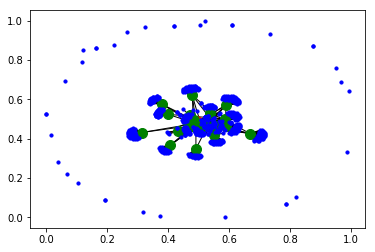

In [269]:
# Visualize the graph
network_graph = nx.Graph(clean_network)
pos=nx.spring_layout(network_graph, k =0.10, iterations=100)
nx.draw_networkx_nodes(network_graph,pos, nodelist=[user_id],
                       node_size=200, node_color='r')
nx.draw_networkx_nodes(network_graph,pos, nodelist=list(first_nodes),
                       node_size=100, node_color='g')
nx.draw_networkx_nodes(network_graph,pos, nodelist=list(second_nodes),
                       node_size=10, node_color='b')
nx.draw_networkx_edges(network_graph,pos)

In [264]:
type(network[10796602])

numpy.ndarray

# 2. Discover some of the properties of the collected network

## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [ ]:
W=np.zeros([len(all_nodes),len(all_nodes)], dtype=int)

In [ ]:
for row in range(0,len(all_nodes)):
    for col in range(0,len(all_nodes)):
         # A node cannot be adjacent to itself
        if row is col:    
            W[row][col] = 0
        #Check if there's an edge connectiong the nodes
        elif (all_nodes[row] in network[all_nodes[col]]) or (all_nodes[col] in network[all_nodes[row]]):
            W[row][col] = 1
        else:
            W[row][col] = 0

Remember that a weight matrix should be symmetric. Check if it is:

In [ ]:
np.nonzero(W-W.transpose())

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

**Your answer here:** It could have happened in the cases where a user doesn't let us check its contacts if we programmed differently. Indeed, if we used only the entry in the dictionary "network" associated with the node to populate the array, if the entry wouldn't contain a connection that is in the dictionary associated the other node, then there could be mismatch. Because we use both the dictionary entry for the node and the dictionary entry of its potential connection in the edge boolean detector, this case cannot happen.

Impose your weight matrix to be symmetric.

In [ ]:
# Make W is symmetric
bigger = W.transpose() > W

In [ ]:
W = W - W*bigger + W.transpose()*bigger

Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

In [ ]:
# your code here
plt.title('Adjacency Matrix W')
plt.spy(W,markersize=2)

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

**Your answer here:**
* Maximum number of links : the maximum number of links is attained when every node is connected to every other node. It is given by:
$$ L_{max} = (N*N-1) / 2$$
N-1 used to remove the diagonal from the count

In [ ]:
Lmax=len(W)*(len(W)-1) /2
print(Lmax)

* How many links in collected network:
We simply have to make the sum of the links in the network and divide it by two 
$$ L_W = \frac{1}{2} \sum_{i=0}^{len(W)-1}\sum_{j=0}^{len(W[0])-1}W(i)(j)$$

In [ ]:
LW = np.sum(W)/2
print("There are {} links in the collected network".format(LW))

* Comment on how L and Lmax compare: 
We can see that L is over an order of magnitude smaller than $L_{max}$. This means that we have a very sparse graph. This is indeed the case as we have seen from the adjacent matrix.

## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

In [ ]:
p = [np.sum(W[index]) for index in range(0, len(W))]

In [ ]:
plt.hist(p, bins=range(0,np.amax(p)+2), normed=True, rwidth = 0.5, align='left')
plt.title("Degree distribution of the Weight matrix")
plt.xlabel("Number of links")
plt.ylabel("Probability of occurence")
plt.show()

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

We can see that there's a high proportion of nodes that have a small number of links. Then, we see that there's some nodes having many links (over 10). There's nearly no nodes in-between.

The degree distribution we obtain is actually very artificial, because we use a very limited scope for the links between nodes. Indeed, if we added more level of nodes than only two, there would be more and more nodes with a higher number of links and some nodes with a very high number of links.

Though, it is probable that there's a lot of nodes in the twitter network that have very few connections. Indeed, multiple cases can cause that: users that follows a lot of accounts and are not followed by many (lurkers), users that are followed by a lot of accounts, but don't follow many (Politicians, Organisations, Stars, etc.) and users that are simply not very active and therefore don't have many connections.

## 2.3 Average degree

Calculate the average degree of your collected network.

In [ ]:
d_avg = np.average(p)
print(d_avg)

## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

Our graph originates with the twitter page of the "user_id" user, we will call the associated node "Source". Every nodes is added with a link to the Source node or with a link to a node that has a link to the Source node. Because of this, the longest path from any node to the source is 2. Even without seeing the actual graph, we can infer from this that the diameter of the network has an upper boundary of 4: any two pair of nodes that we will connect together have a maximum distance to the Source of 2 and therefore a maximum distance between them of 4.

To find out if this is the case in our graph, we can simply check if two second order nodes that have no other connections than their first order node and for which the first order nodes are not connection. This is sufficient to prove that the maximum distance is 4.

In [ ]:
# Prove or disprove the presence of a node at distance 4
lonely_nodes = []
found_distance_four = False
for node in second_nodes:
    # Find all nodes who have only a parent as a connection
    if len(network[node]) is 1:
        lonely_nodes.append(node)
for node in lonely_nodes:
    if found_distance_four:
        break
    for other_node in lonely_nodes:
        # Check if they have the same parent
        if not (network[node][0] in network[other_node]):
            # Check if their parents are connected
            if not (network[node][0] in network[other_node] or network[other_node][0] in network[node]):
                print("Found two nodes at distance 4, node {} and node {}".format(node, other_node))
                print("Diameter must be 4")
                found_distance_four = True
                break
if not found_distance_four:
    print("No nodes at distance four, diameter is most likely 3")

## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [ ]:
# Create a new version of the all_nodes array with only the
# nodes that contain more than the average of connections
pruned_all_nodes = [node for node in all_nodes \
                    if (len(network[node]) > d_avg)]
Wpruned = np.zeros([len(pruned_all_nodes),len(pruned_all_nodes)], dtype=int)                      
for row in range(0,len(pruned_all_nodes)):
    for col in range(0,len(pruned_all_nodes)):
         # A node cannot be adjacent to itself
        if row is col:    
            Wpruned[row][col] = 0
        #Check if there's an edge connectiong the nodes
        elif (pruned_all_nodes[row] in network[pruned_all_nodes[col]]) \
                        or (pruned_all_nodes[col] in network[all_nodes[row]]):
            Wpruned[row][col] = 1
        else:
            Wpruned[row][col] = 0
                        

In [ ]:
# Note: Some node don't have the proper number of links because they were
#       linked to node that have been removed
plt.spy(Wpruned, markersize=5)
plt.title('Adjacency Matrix W');

In [ ]:
# Visualize the graph
# We superpose it over the results from the previous graph to show which 
# nodes made it through
pruned_network_graph= nx.Graph(network)
pos=nx.spring_layout(pruned_network_graph, iterations=150)
nx.draw_networkx_nodes(pruned_network_graph,pos, nodelist=[user_id],
                       node_size=600, node_color='r')
nx.draw_networkx_nodes(pruned_network_graph,pos, nodelist=list(first_nodes),
                       node_size=500, node_color='g')
nx.draw_networkx_nodes(pruned_network_graph,pos, nodelist=list(pruned_all_nodes),
                       node_size=200, node_color='b')
nx.draw_networkx_edges(pruned_network_graph,pos)